# Generative Modeling with VAE (EEG Data Augmentation)

##### Objective: 
The aim of this method is to develop a generative model capable of augmenting EEG datasets by synthesizing realistic EEG signals. Using a Variational Autoencoder (VAE)-based approach, we aim to learn latent representations of EEG data and generate new samples that preserve the statistical properties of real EEG signals.

##### Why have we decided to go with this approach ?
We have decided to use the Variational Autoencoder (VAE) approach for EEG data augmentation for several compelling reasons, supported by research of these papers:
https://www.researchgate.net/publication/377496700_Data_augmentation_for_invasive_brain-computer_interfaces_based_on_stereo-electroencephalography_SEEG
https://www.researchgate.net/publication/370002394_Dual-encoder_VAE-GAN_with_Spatiotemporal_Features_for_Emotional_EEG_Data_Augmentation
https://iopscience.iop.org/article/10.1088/1741-2552/abb580

Thus, given the strong results in EEG classification, and data augmentation, we chose VAE as our primary approach to synthesize realistic EEG signals.

##### Research question overview

How can we develop more effective generative models for EEG data augmentation that preserve both the spatial and temporal dynamics of neural signals?  
How does VAE-based augmentation compare to traditional augmentation techniques in EEG analysis?

##### In this notebook, we have three parts as below

# PART A: EEG Preprocessing 

The key steps are:
1. Loading EEG Data
2. Applying filtering (notch & bandpass) and removing artifacts using Independent Component Analysis (ICA).
3. Epoching
4. Visualization

In [105]:
# Importing Libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import h5py
from mne.preprocessing import ICA
import seaborn as sns
import platform
import scipy.stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import wasserstein_distance
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from tensorflow.keras.models import load_model

In [106]:
# Set the aesthetic style for plots using seaborn
# whitegrid style provides grid lines, viridis palette for color scheme, and font_scale=1.2 for better readability
                       
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.2)

# Print the OS information for troubleshooting and reproducibility
print("Running on:", platform.platform())

Running on: Windows-10-10.0.19045-SP0


In [107]:
# Define subject ID and file paths

subject_id = 2
data_root = r"C:\Users\AaVerma\OneDrive - Heidelberg Materials\Desktop\Raw_\Raw Dataset"
subject_folder = f"Sub{subject_id}"
eeg_folder = os.path.join(data_root, subject_folder, "EEG")

# Define paths to the .mat files containing EEG data

cnt_file = os.path.join(eeg_folder, "cnt.mat")
mrk_file = os.path.join(eeg_folder, "mrk.mat")


# Check if files exist

if not os.path.exists(cnt_file):
    raise FileNotFoundError(f"Cannot find {cnt_file}. Please check your dataset path.")
if not os.path.exists(mrk_file):
    raise FileNotFoundError(f"Cannot find {mrk_file}. Please check your dataset path.")

### Defining a helper function to resolve HDF5 references and convert to readable values.
This is necessary because MATLAB files stored as HDF5 often contain references instead of direct values, especially for strings and arrays.
### This function handles MATLAB's HDF5 references which can be tricky to work with in Python

In [108]:
def resolve_references(mat_file, ref_path):
    refs = mat_file[ref_path]
    resolved = []
    for ref in refs:
        try:
            
            # Checking if it's a reference
            if isinstance(ref, h5py.h5r.Reference):
                
                # Dereference and get the value
                deref = mat_file[ref]
                
                # Trying to decode if bytes, otherwise converting it to string
                val = deref[()].decode('utf-8') if isinstance(deref[()], bytes) else str(deref[()])
                resolved.append(val)
            else:
                # If not a reference, convert directly
                resolved.append(str(ref))
        except Exception as e:
            print(f"Error resolving reference: {e}")
            resolved.append('Unknown')
    return resolved

In [109]:
# Trying to load the MATLAB files using h5py (for MATLAB v7.3+ files)

try:
    cnt_mat = h5py.File(cnt_file, mode="r")
    mrk_mat = h5py.File(mrk_file, mode="r")
    print("Files loaded successfully with h5py")
except Exception as e:
    print(f"Error loading files: {e}")
    raise

Files loaded successfully with h5py


### Resolve event type references specifically for marker data.
Event markers in MATLAB EEG files often have a complex structure and need special handling to extract the numeric event codes.
### This handles different possible structures of the event type data in MATLAB files

In [110]:
def resolve_event_references(mat_file):
    event_group = mat_file['mrk']['event']
    
    # Check the structure of event type
    if isinstance(event_group['type'], h5py.Dataset):
        
        # If it's a direct dataset
        event_types = event_group['type'][()]
    elif isinstance(event_group['type'], h5py.Reference):
        
        # If it's a reference, dereference it
        event_types = mat_file[event_group['type'][()]][()]
    else:
        # If neither, try to get the values
        event_types = event_group['type'][()]
    
    # Flatten and convert to integer
    if isinstance(event_types, np.ndarray):
        event_types = event_types.flatten()

    event_types = np.array([int(et) if isinstance(et, (int, float, np.number)) else 0 for et in event_types])
    
    return event_types

In [111]:
# Resolve channel labels from the EEG data file

clab_resolved = resolve_references(cnt_mat, 'cnt/clab')
print("Resolved Channel Labels:", clab_resolved)

Resolved Channel Labels: ['[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object reference>]', '[<HDF5 object re

In [112]:
# Extracting EEG data and sampling frequency
eeg_data = np.array(cnt_mat['cnt']['EEG'][()])
fs = float(np.array(cnt_mat['cnt']['fs'][()]).item())

print("EEG data shape:", eeg_data.shape)
print("Sampling frequency:", fs)

EEG data shape: (3691800, 63)
Sampling frequency: 1000.0


In [36]:
# Extract markers
mrk_time = np.array(mrk_mat['mrk']['time'][()]).flatten().astype(int)
mrk_event_type = resolve_event_references(mrk_mat)

print("Marker times shape:", mrk_time.shape)
print("Marker event shape:", mrk_event_type.shape)

Marker times shape: (160,)
Marker event shape: (160,)


### We perform MNE processing on EEG data to ensure the signals are clean, structured, and ready for analysis.  First, MNE helps remove noise and artifacts such as powerline interference or eye blinks—using filters and Independent Component Analysis (ICA).
### Next, it segments continuous EEG recordings into time-locked epochs (e.g., 5-second windows), for synthetic data generation. The data is then standardized (normalized per channel) to ensure consistent scaling, which is crucial for both accurate analysis and stable training. 
### MNE also provides visualization tools to inspect data quality, and compares real and synthetic EEG plots. Essentially, MNE processing transforms raw, messy EEG into reliable, analysis-ready data—just like the preprocessed real data used to train for synthetic EEG generation. Without these steps, the results would be noisy, inconsistent, or unusable for downstream tasks.

In [113]:
# Prepare data for MNE-Python processing
eeg_data = eeg_data.T

# Create unique channel labels if duplicate exists as it requires uniques channels to function properly
if len(set(clab_resolved)) != len(clab_resolved):
    clab_resolved = [f'CH_{i+1}' for i in range(len(clab_resolved))]

# Create the MNE info object with unique channel labels
info = mne.create_info(ch_names=clab_resolved, sfreq=fs, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)

Creating RawArray with float64 data, n_channels=63, n_times=3691800
    Range : 0 ... 3691799 =      0.000 ...  3691.799 secs
Ready.


In [38]:
# Prepare events for epoching
events = np.column_stack((mrk_time, np.zeros(len(mrk_time), dtype=int), mrk_event_type))

In [114]:
# Applying Preprocessing
raw.notch_filter(freqs=[50], picks='eeg')
raw.filter(l_freq=1.0, h_freq=40.0, picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


<RawArray | 63 x 3691800 (3691.8 s), ~1.73 GiB, data loaded>

In [115]:
# Independent Component Analysis (ICA) for artifact removal

ica = ICA(n_components=20, random_state=42)
ica.fit(raw)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 234.7s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,65 iterations on raw data (3691800 samples)
ICA components,20
Available PCA components,63
Channel types,eeg
ICA components marked for exclusion,—


In [116]:
# Automated artifact detection using kurtosis
# This approach detects non-Gaussian components which are often artifacts

sources = ica.get_sources(raw)
source_data = sources.get_data()

In [117]:
# Compute kurtosis for each source as a measure of non-Gaussianity
# Artifacts like eye blinks typically have high kurtosis values

kurtosis_values = np.abs(scipy.stats.kurtosis(source_data, axis=1))

In [119]:
# Identify artifacts using a statistical threshold
# Components with kurtosis above mean + 2*std are likely artifacts

threshold = np.mean(kurtosis_values) + 2 * np.std(kurtosis_values)
artifact_indices = np.where(kurtosis_values > threshold)[0]
print("Potential artifact components:", artifact_indices)

# Apply ICA cleaning by excluding artifact components
ica.exclude = list(artifact_indices)
raw_clean = ica.apply(raw.copy())

Potential artifact components: [9]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 63 PCA components


In [121]:
# Downsample data to reduce computational load and file size.
# 200 Hz is sufficient for most EEG analyses while preserving important signal features

raw_clean.resample(200)

Sampling frequency of the instance is already 200.0, returning unmodified.


<RawArray | 63 x 738360 (3691.8 s), ~354.9 MiB, data loaded>

In [122]:
# Epoching - segment continuous data into trials

tmin, tmax = 0.0, 5.0 # Define epoch time window: 0 to 5 seconds

epochs = mne.Epochs(raw_clean, events=events, tmin=tmin, tmax=tmax, baseline=None, preload=True)
data = epochs.get_data()

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 160 events and 1001 original time points ...
130 bad epochs dropped


In [123]:
# Normalization - standardize each channel within each epoch

for i in range(data.shape[0]):
    ch_means = np.mean(data[i], axis=1, keepdims=True)
    ch_stds = np.std(data[i], axis=1, keepdims=True)
    data[i] = (data[i] - ch_means) / (ch_stds + 1e-8)
epochs_normalized = mne.EpochsArray(data, info=epochs.info, events=epochs.events)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


<Figure size 1200x600 with 0 Axes>

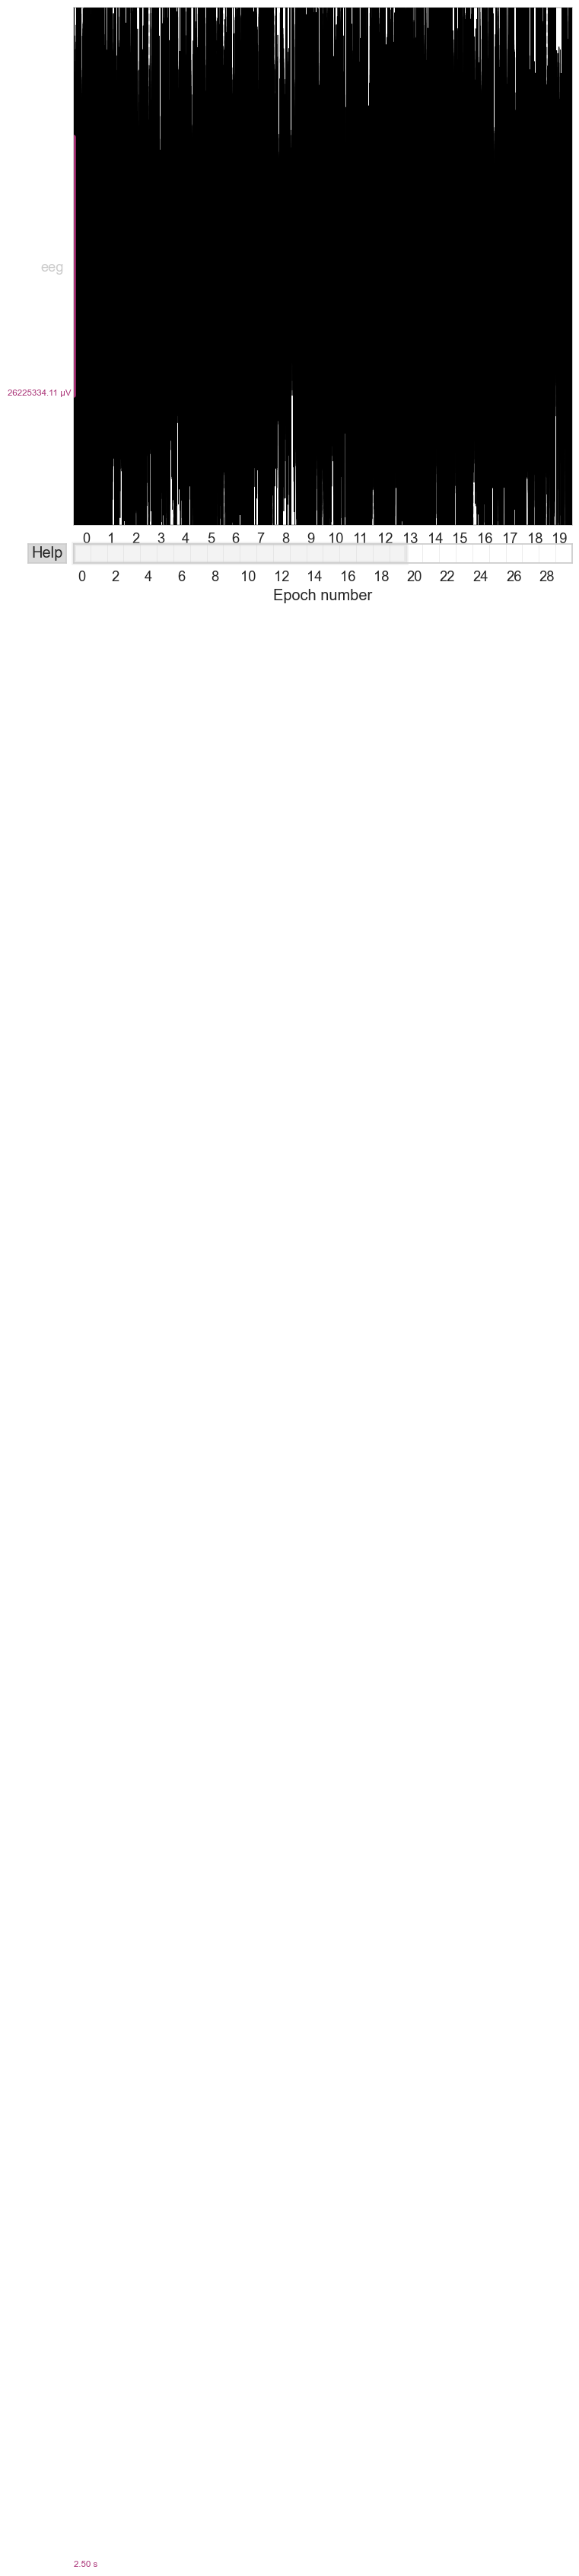

<Figure size 1200x600 with 0 Axes>

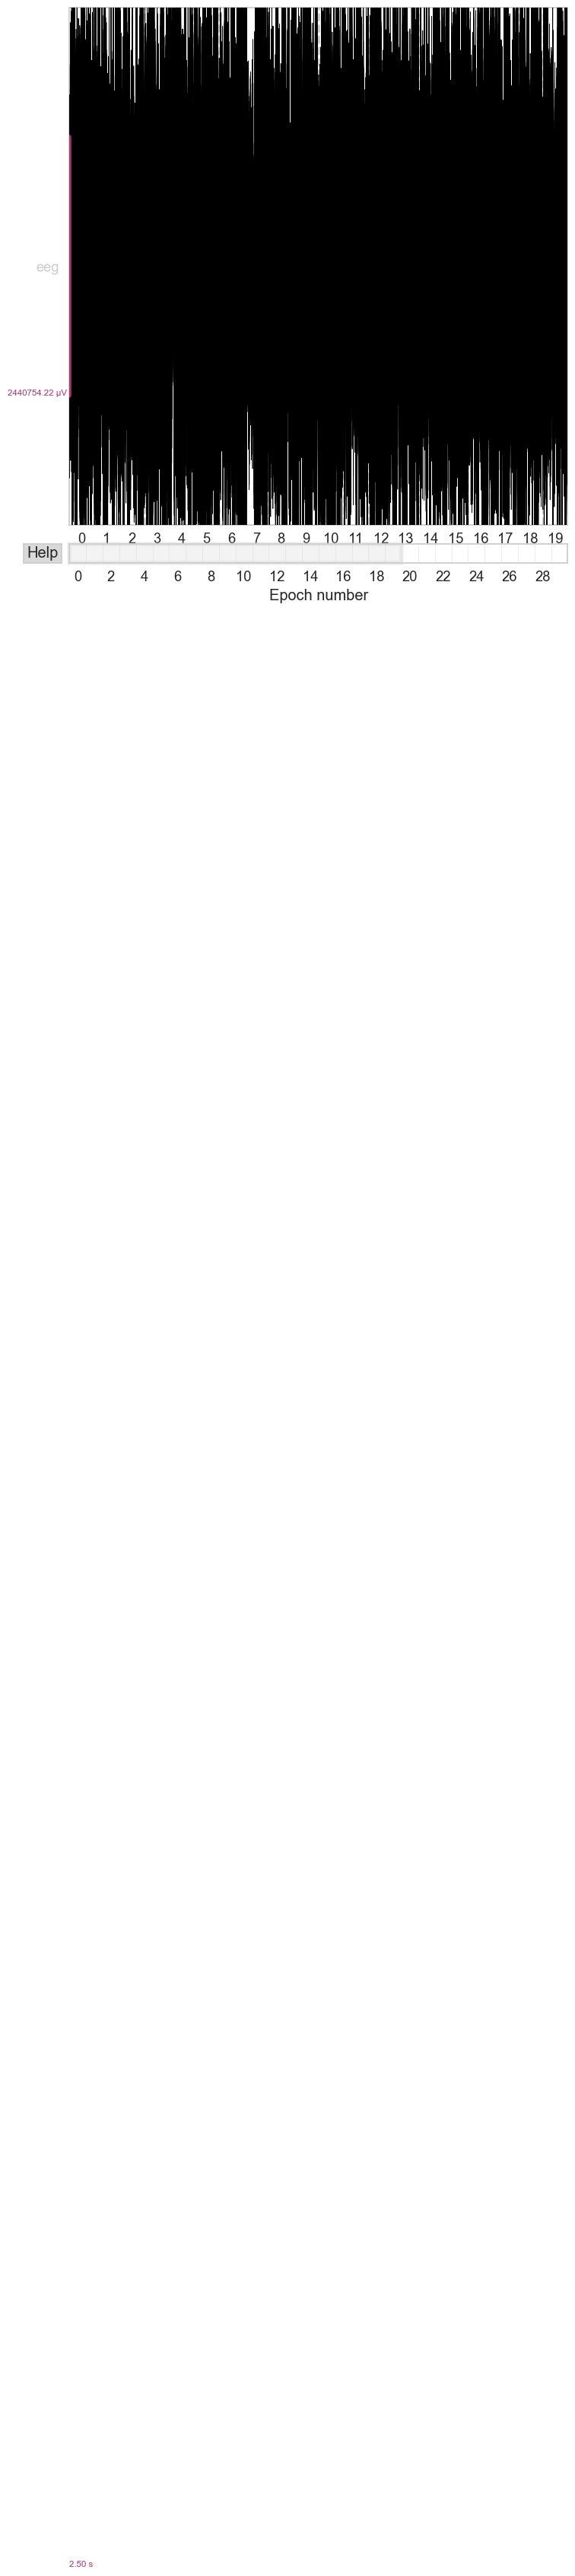

In [124]:
# Plotting the results:

# Plot original filtered and ICA cleaned epochs
plt.figure(figsize=(12, 6))
epochs.plot(n_channels=5, picks='eeg', scalings='auto', title="Original Filtered & ICA Cleaned (Epochs)", show=False, butterfly=True)
plt.show()

# Plot normalized epochs
plt.figure(figsize=(12, 6))
epochs_normalized.plot(n_channels=5, picks='eeg', scalings='auto', title="Normalized Epochs", show=False, butterfly=True)
plt.show()

# PART B: EEG Data Augumentation with Variational Autoencoder (VAE)

The key steps are:
1. Data Preparation
2. Defining the Variational Autoencoder (VAE)
3. Training the VAE
4. Generating Synthetic EEG Data
5. Comparison Between Real and Synthetic EEG

In [126]:
# Extract EEG data from preprocessed epochs
# Shape: (n_epochs, n_channels, n_samples) represents the structure of EEG extracted data

data = epochs_normalized.get_data()
n_epochs, n_channels, n_samples = data.shape

# Convert data to PyTorch tensor for model training
data_tensor = torch.tensor(data, dtype=torch.float32)

# Creating DataLoader for batch processing
dataloader = DataLoader(TensorDataset(data_tensor), batch_size=32, shuffle=True)

In [127]:
# Define the Variational Autoencoder (VAE)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder: Extracts latent features from input EEG data
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=n_channels, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space representation
        self.fc_mu = nn.Linear(32 * n_samples, latent_dim)
        self.fc_logvar = nn.Linear(32 * n_samples, latent_dim)
        
        # Decoder: Reconstructs EEG data from latent representations
        self.decoder_fc = nn.Linear(latent_dim, 32 * n_samples)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=n_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    # Applies the reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    #Forward pass through the VAE
    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder_fc(z).view(-1, 32, n_samples)
        decoded = self.decoder(decoded)
        return decoded, mu, logvar

In [129]:
# Initialize VAE Model
# Used ADAM optimizer for training

latent_dim = 16
vae = VAE(input_dim=n_samples, latent_dim=latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

### We used the Adam optimizer in this Variational Autoencoder (VAE) for EEG synthesis because VAEs involve learning both the reconstruction loss and the KL-divergence loss, which require stable gradient updates. Adam is commonly used in VAEs for its robustness in handling such complex loss functions.
### Also, EEG data can be noisy, and Adam performs well in such scenarios by smoothing out updates.

In [130]:
# Defined VAE loss function
# Combines Reconstruction loss (MSE) and KL Divergence for regularization

def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [131]:
# Train the VAE model

num_epochs = 50
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

Epoch 1, Loss: 4.921138763427734
Epoch 2, Loss: 1952.1011962890625
Epoch 3, Loss: 100.50375366210938
Epoch 4, Loss: 265.1518859863281
Epoch 5, Loss: 543.4971313476562
Epoch 6, Loss: 517.8070068359375
Epoch 7, Loss: 377.9765319824219
Epoch 8, Loss: 259.6785583496094
Epoch 9, Loss: 196.7224884033203
Epoch 10, Loss: 174.98635864257812
Epoch 11, Loss: 171.44802856445312
Epoch 12, Loss: 169.30564880371094
Epoch 13, Loss: 160.70956420898438
Epoch 14, Loss: 144.76791381835938
Epoch 15, Loss: 124.19397735595703
Epoch 16, Loss: 102.31405639648438
Epoch 17, Loss: 81.80104064941406
Epoch 18, Loss: 64.11957550048828
Epoch 19, Loss: 49.76540756225586
Epoch 20, Loss: 38.554420471191406
Epoch 21, Loss: 30.030569076538086
Epoch 22, Loss: 23.623310089111328
Epoch 23, Loss: 18.809846878051758
Epoch 24, Loss: 15.170665740966797
Epoch 25, Loss: 12.38570785522461
Epoch 26, Loss: 10.221723556518555
Epoch 27, Loss: 8.51434326171875
Epoch 28, Loss: 7.146718502044678
Epoch 29, Loss: 6.045582294464111
Epoch 30,

In [133]:
# Generate new synthetic EEG samples using trained VAE

vae.eval()

# Generate 10 random latent samples
z_sample = torch.randn(10, latent_dim)
synthetic_eeg = vae.decoder_fc(z_sample).view(-1, 32, n_samples)
synthetic_eeg = vae.decoder(synthetic_eeg).detach().numpy()

In [134]:
print("Generated Synthetic EEG Shape:", synthetic_eeg.shape)

Generated Synthetic EEG Shape: (10, 63, 1001)


In [135]:
# Extracted 10 real EEG samples for comparison

real_eeg = epochs_normalized.get_data()[:10]
real_eeg = real_eeg[:, :, :synthetic_eeg.shape[2]]

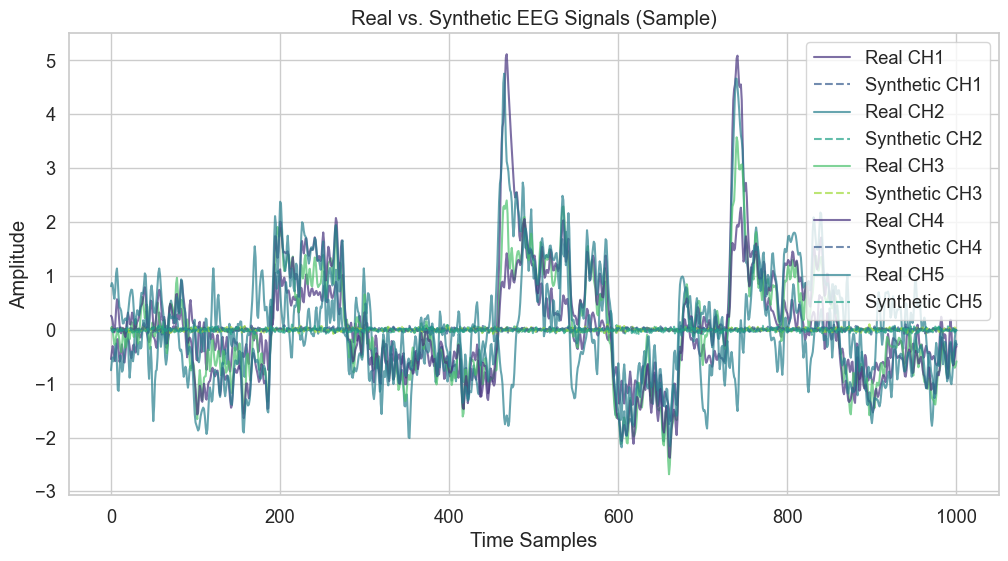

In [136]:
# Plot comparison of real vs. synthetic EEG signals

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(real_eeg[0, i, :], label=f'Real CH{i+1}', alpha=0.7)
    plt.plot(synthetic_eeg[0, i, :], linestyle='dashed', label=f'Synthetic CH{i+1}', alpha=0.7)
plt.legend()
plt.title("Real vs. Synthetic EEG Signals (Sample)")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()

In [137]:
# Compute Power Spectral Density (PSD) to compare frequency distributions

def compute_psd(eeg_data):
    psd_values = []
    for trial in eeg_data:
        psds, freqs = mne.time_frequency.psd_array_multitaper(trial, sfreq=200, fmin=1, fmax=40, verbose=False)
        psd_values.append(np.mean(psds, axis=0))
    return np.array(psd_values), freqs

real_psd, freqs = compute_psd(real_eeg)
synthetic_psd, _ = compute_psd(synthetic_eeg)

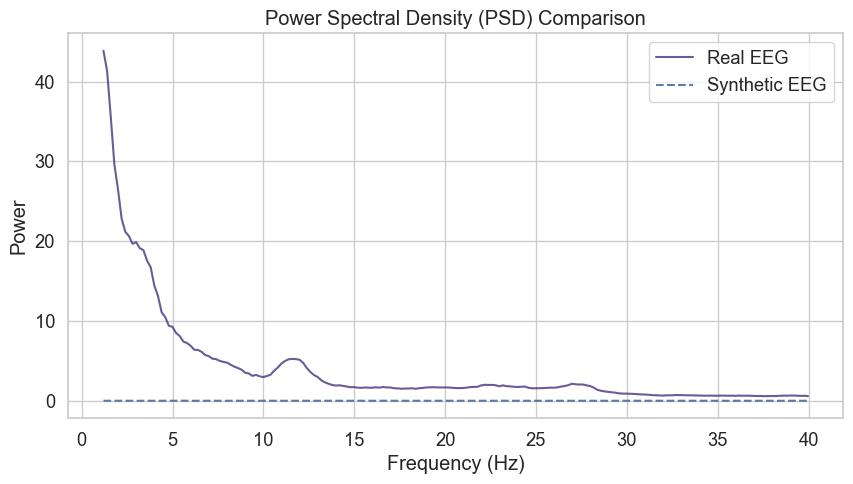

In [138]:
# Plot PSD comparison

plt.figure(figsize=(10, 5))
plt.plot(freqs, np.mean(real_psd, axis=0), label="Real EEG", alpha=0.8)
plt.plot(freqs, np.mean(synthetic_psd, axis=0), linestyle='dashed', label="Synthetic EEG", alpha=0.8)
plt.title("Power Spectral Density (PSD) Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.show()

In [139]:
# Compute statistical similarity metrics

real_mean, real_std = np.mean(real_eeg), np.std(real_eeg)
synthetic_mean, synthetic_std = np.mean(synthetic_eeg), np.std(synthetic_eeg)
correlation = scipy.stats.pearsonr(real_eeg.flatten(), synthetic_eeg.flatten())[0]
fd_distance = wasserstein_distance(real_eeg.flatten(), synthetic_eeg.flatten())

In [140]:
print(f"Mean (Real vs Synthetic): {real_mean:.4f} vs {synthetic_mean:.4f}")
print(f"Std Dev (Real vs Synthetic): {real_std:.4f} vs {synthetic_std:.4f}")
print(f"Pearson Correlation: {correlation:.4f}")
print(f"Fréchet Distance: {fd_distance:.4f}")

Mean (Real vs Synthetic): 0.0000 vs 0.0003
Std Dev (Real vs Synthetic): 1.0000 vs 0.0403
Pearson Correlation: 0.0126
Fréchet Distance: 0.7330


In [141]:
# Perform t-SNE visualization of EEG feature distributions

real_features = real_psd.reshape(real_psd.shape[0], -1)
synthetic_features = synthetic_psd.reshape(synthetic_psd.shape[0], -1)
combined_features = np.vstack((real_features, synthetic_features))
labels = ['Real'] * real_features.shape[0] + ['Synthetic'] * synthetic_features.shape[0]

In [142]:
# Adjust perplexity to be less than the number of samples

perplexity = min(30, combined_features.shape[0] - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
embedded = tsne.fit_transform(combined_features)

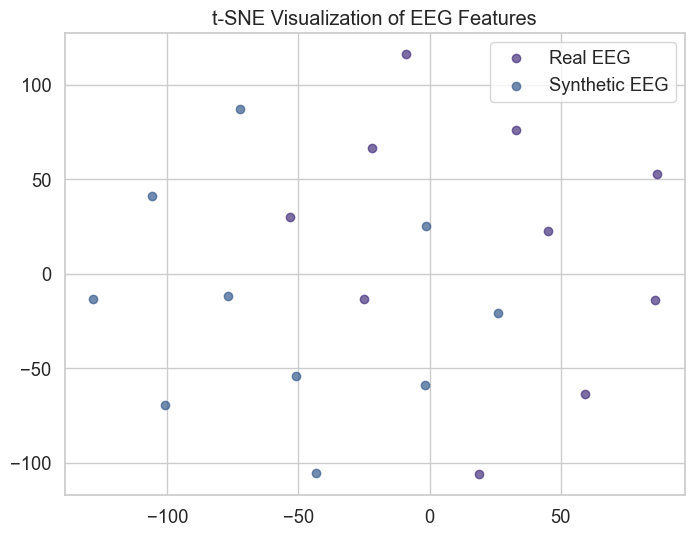

In [143]:
plt.figure(figsize=(8, 6))
plt.scatter(embedded[:real_features.shape[0], 0], embedded[:real_features.shape[0], 1], label="Real EEG", alpha=0.7)
plt.scatter(embedded[real_features.shape[0]:, 0], embedded[real_features.shape[0]:, 1], label="Synthetic EEG", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of EEG Features")
plt.show()

# Part C: EEG Data Source Localization

The key steps are: 
1. Setted up Parallel Processing to optimise performance when handling large EEG data files
2. Loaded the trained VAE Encoder and EEG data from .mat files
3. Identify the Best EEG File Based on Variance
4. Extract Latent Representations Using VAE
5. Apply K-Means Clustering on Latent Representations
6. Extract and Map Cluster Activity to Electrodes
7. Visualize EEG Source Localization

In [144]:
# Setting the number of threads for parallel processing to improve performance
os.environ["OMP_NUM_THREADS"] = "4"

In [145]:
# Load the trained VAE encoder model for feature extraction
encoder = load_model(r'C:\Users\AaVerma\OneDrive - Heidelberg Materials\Desktop\Raw_\Raw Dataset\preprocessed_dataset\vae_encoder.h5')

In [146]:
# Function to load EEG data from .mat files

def load_cnt_data(file_path):
    with h5py.File(file_path, 'r') as f:
        return np.array(f['cnt'])

In [147]:
# Function to compute variance of EEG Data which helps in determining Signal Strength
def compute_variance(data):
    return np.var(data)

In [148]:
# Define the folder containing EEG files

folder = r'C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/'
best_file = None
best_variance = 0

In [149]:
# Iterate over all files and select the one with the highest variance

for file in os.listdir(folder):
    if file.endswith("_cnt.mat"):
        cnt_file = os.path.join(folder, file)
        data = load_cnt_data(cnt_file)
        variance = compute_variance(data)
        if variance > best_variance:
            best_variance = variance
            best_file = cnt_file

### We choose the EEG file with the highest variance because:
##### 1. Higher Variance = More Informative EEG Data
##### 2. To avoid Flat or Low-Signal EEG Data
##### 3. Better Feature Extraction with VAE

##### We used K-Means clustering in EEG analysis to group similar brain activity patterns based on the extracted latent features from the Variational Autoencoder (VAE). Since EEG signals are complex and high-dimensional, the VAE helps compress them into a lower-dimensional representation, making clustering more effective. 

##### By associating each electrode’s activity with a cluster, we enhance the visualization of brain activity distribution across the scalp using a topographic heatmap. 

Processing and visualizing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub40_cnt.mat...
163688/163688 ━━━━━━━━━━━━━━━━━━━━ 119s 724us/step


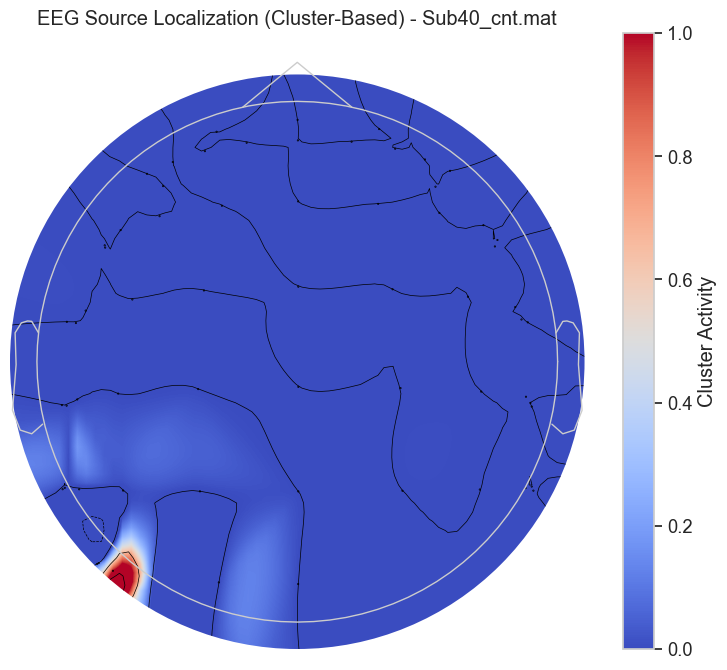

In [150]:
# If a valid EEG file is found, process and visualize it

if best_file:
    print(f"Processing and visualizing {best_file}...")
    eeg_data = load_cnt_data(best_file)
    num_samples, num_channels = eeg_data.shape

    # Ensure the EEG data has 64 channels
    if num_channels < 64:
        eeg_data = np.pad(eeg_data, ((0, 0), (0, 64 - num_channels)), mode='constant')

    # Extract latent features using the trained VAE encoder
    latent_representations = encoder.predict(eeg_data)

    # Perform K-Means clustering on extracted latent features
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(latent_representations)

    # EEG Source Localization Setup
    montage = mne.channels.make_standard_montage("standard_1020")
    info = mne.create_info(ch_names=montage.ch_names[:64], sfreq=250, ch_types=['eeg'] * 64)
    info.set_montage(montage, match_case=False)

    # Extract 2D Electrode Positions
    ch_positions = montage.get_positions()['ch_pos']
    pos = np.array([ch_positions[ch][:2] for ch in info.ch_names])

    # Map cluster activity to EEG channels
    activity = np.zeros(64, dtype=np.float64)
    cluster_indices = np.linspace(0, num_samples - 1, 64, dtype=int)
    for i, ch_idx in enumerate(cluster_indices):
        activity[i] = kmeans_labels[ch_idx]

    # Normalize activity for visualization
    if activity.max() > activity.min():
        activity = (activity - activity.min()) / (activity.max() - activity.min())
    else:
        activity = np.zeros(64)

    # Plot EEG Source Localization using cluster-based activity
    fig, ax = plt.subplots(figsize=(10, 8))
    im, _ = mne.viz.plot_topomap(activity, pos, axes=ax, contours=3, cmap='coolwarm', show=False)
    cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap='coolwarm'), ax=ax)
    cbar.set_label("Cluster Activity")
    plt.title(f"EEG Source Localization (Cluster-Based) - {os.path.basename(best_file)}")
    plt.show()

##### The output is a topographic map visualizing EEG source localization based on cluster activity derived from the file. 
##### The map displays neural activity distribution across the scalp using a color gradient from blue (low activity, 0.0) to red (high activity, 1.0), with contour lines delineating regions of similar activity.
##### The color bar indicates normalized cluster strength, with values ranging between 0.0 and 1.0